# Importing Packages

In [ ]:
!pip install tensorflow

In [2]:
%%capture
!pip install category_encoders==2.*

In [154]:
import pandas as pd

import tensorflow as tf
from tensorflow.keras.optimizers import Adam

import numpy as np

import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from category_encoders import OrdinalEncoder

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

# Configuring data + determining baseline (for reference)

In [289]:
df = pd.read_csv('/content/data.csv')
df = df.drop(columns=['Damage', 'Timestamp', 'Name'])

In [290]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2048 entries, 0 to 2047
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Type    2048 non-null   object 
 1   Level   2048 non-null   int64  
 2   Rarity  2048 non-null   object 
 3   Health  2048 non-null   float64
 4   Energy  2048 non-null   float64
 5   Sanity  2048 non-null   float64
dtypes: float64(3), int64(1), object(2)
memory usage: 96.1+ KB


In [291]:
label_encoder = LabelEncoder()
df['Type'] = label_encoder.fit_transform(df['Type'])
df['Rarity'] = label_encoder.fit_transform(df['Rarity'])

In [292]:
df.head()

,Type,Level,Rarity,Health,Energy,Sanity
0,1,3,0,6.24,6.48,6.30
1,0,4,0,7.06,8.58,7.59
2,2,6,1,24.55,23.27,22.35
3,1,6,0,11.42,11.83,11.85
4,0,3,4,34.27,33.47,25.19


In [293]:
target = 'Rarity'
X,y = df.drop(columns = target), df[target]

In [294]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [295]:
y_train.head()

1671    0
952     0
1677    2
1251    4
482     3
Name: Rarity, dtype: int64

In [296]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1638, 5), (410, 5), (1638,), (410,))

In [297]:
print('The baseline accuracy is ', y_train.value_counts(normalize=True).max())

The baseline accuracy is  0.3021978021978022


# Random Forest Classifier

In [298]:
model_rf = make_pipeline(
    SimpleImputer(strategy='median'),
    RandomForestClassifier(random_state=42, n_jobs=-1,n_estimators=75)
)

# Fit on train, score on val
model_rf.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('randomforestclassifier',
                 RandomForestClassifier(n_estimators=75, n_jobs=-1,
                                        random_state=42))])

In [299]:
y_pred_rf = model_rf.predict(X_test)
y_pred_proba_rf = model_rf.predict_proba(X_test)

In [300]:
y_pred_proba_rf

array([[1.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.10666667, 0.85333333, 0.01333333, 0.02666667,
        0.        ],
       [0.        , 0.        , 0.        , 0.09333333, 0.72      ,
        0.18666667],
       ...,
       [0.        , 0.        , 1.        , 0.        , 0.        ,
        0.        ],
       [0.97333333, 0.02666667, 0.        , 0.        , 0.        ,
        0.        ],
       [1.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ]])

In [74]:
# Impressive Validation accuracy
# Since the difference between training acc and val acc isn't substantial, most likely there is no overfitting despite train acc being 1.0
print('Training Accuracy', model_rf.score(X_train, y_train))
print('Validation Accuracy', model_rf.score(X_test, y_test))

Training Accuracy 1.0
Validation Accuracy 0.9707317073170731


This graph tells me that "Level" is a significantly important feature that determines the rarity of a monster

Text(0, 0.5, 'Feature')

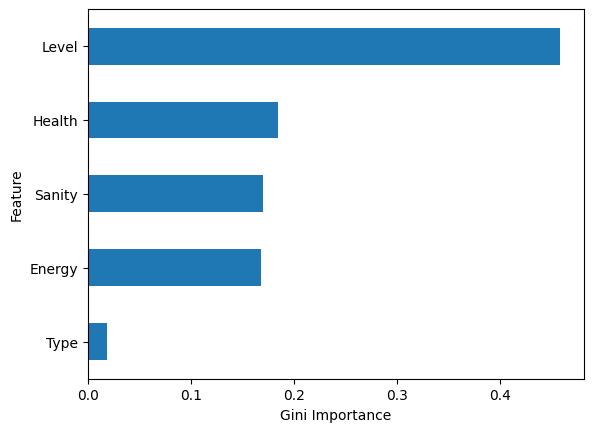

In [311]:
# FEATURE IMPORTANCE
importances = model_rf.named_steps['randomforestclassifier'].feature_importances_
feature_names = X_train.columns
feat_imp = pd.Series(data=importances, index=feature_names).sort_values()
feat_imp.tail(10).plot(kind='barh')
plt.xlabel('Gini Importance')
plt.ylabel('Feature')

# Tensorflow Model

In [249]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [29]:
def create_model(lr=0.1):

  opt = Adam(learning_rate=lr)
  model = tf.keras.Sequential([
      tf.keras.layers.Dense(32, activation='relu', input_shape=(5,)),
      tf.keras.layers.Dense(16, activation='relu'),
      tf.keras.layers.Dense(6, activation='softmax')
  ])

  model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

  return model

In [30]:
create_model().summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 32)                192       
                                                                 
 dense_16 (Dense)            (None, 16)                528       
                                                                 
 dense_17 (Dense)            (None, 6)                 102       
                                                                 
Total params: 822
Trainable params: 822
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model = create_model()
model.fit(X_train, y_train, batch_size=32, validation_data=(X_test, y_test), epochs=50)

# Result w/ default learning rate - Epoch 50/50 52/52 [==============================] - 0s 3ms/step - loss: 0.0522 - accuracy: 0.9890 - val_loss: 0.0508 - val_accuracy: 0.9927
# Result w/ lr=0.1 - Epoch 50/50 52/52 [==============================] - 0s 3ms/step - loss: 0.1284 - accuracy: 0.9640 - val_loss: 0.1000 - val_accuracy: 0.9610

In [ ]:
# Bigger batch size is showing that the model can't generalize well to big batches
model = create_model()
model.fit(X_train, y_train, batch_size=500, validation_data=(X_test, y_test), epochs=50)

# Result = Epoch 50/50 4/4 [==============================] - 0s 21ms/step - loss: 0.6250 - accuracy: 0.7912 - val_loss: 0.6131 - val_accuracy: 0.7951

In [42]:
y_pred_proba_tf = model.predict(X_test)

13/13 [==============================] - 0s 2ms/step


In [206]:
confidence_rate_tf = y_pred_proba_tf.max(axis=1)
confidence_rate_df_tf = pd.DataFrame(confidence_rate_tf)
confidence_rate_df_tf.head()

,0
0,0.901559
1,0.337585
2,0.459763
3,0.490607
4,0.334271


# Logistic Regression

In [179]:
model_lr = LogisticRegression()
model_lr.fit(X_train_scaled, y_train)

LogisticRegression()

In [180]:
train_accuracy = model_lr.score(X_train_scaled, y_train)
test_accuracy = model_lr.score(X_test_scaled, y_test)

In [181]:
print("Training Accuracy:", train_accuracy)
print("Testing Accuracy:", test_accuracy)

Training Accuracy: 0.9267399267399268
Testing Accuracy: 0.9073170731707317


# The Real Test

In [ ]:
!pip install MonsterLab
from MonsterLab import Monster

In [113]:
monsters = []
for _ in range(2048):
  monster_int = Monster().to_dict()
  monsters.append(monster_int)

new_df = pd.DataFrame(monsters)

In [126]:
new_df.head()

,Name,Type,Level,Rarity,Damage,Health,Energy,Sanity,Timestamp
0,Skeletal Knight,Undead,13,Rank 1,13d4,51.25,51.92,50.31,2023-07-08 15:29:18
1,Faerie Dragon,Dragon,3,Rank 0,3d2+2,6.38,5.51,5.36,2023-07-08 15:29:18
2,Flame Spirit,Fey,8,Rank 1,8d4+2,30.27,31.18,32.96,2023-07-08 15:29:18
3,Prince of Fear,Devilkin,20,Rank 4,20d10+1,197.37,204.64,204.78,2023-07-08 15:29:18
4,Revenant,Undead,13,Rank 0,13d2,25.23,25.46,26.64,2023-07-08 15:29:18


In [123]:
new_df_final = new_df.drop(columns=['Damage', 'Timestamp', 'Name'])

In [191]:
label_encoder = LabelEncoder()
new_df_final['Type'] = label_encoder.fit_transform(new_df_final['Type'])
new_df_final['Rarity'] = label_encoder.fit_transform(new_df_final['Rarity'])

In [128]:
new_df_final.head()

,Type,Level,Rarity,Health,Energy,Sanity
0,5,13,1,51.25,51.92,50.31
1,2,3,0,6.38,5.51,5.36
2,4,8,1,30.27,31.18,32.96
3,1,20,4,197.37,204.64,204.78
4,5,13,0,25.23,25.46,26.64


In [168]:
target = 'Rarity'
X_new,y_true = new_df_final.drop(columns = target), new_df_final[target]

In [169]:
X_new.shape, y_true.shape

((2048, 5), (2048,))

**Testing Random Forest**

In [262]:
predictions_rf = model_rf.predict(X_new)

In [276]:
predictions_rf

array([1, 0, 1, ..., 1, 2, 2])

In [281]:
predictions_rf_proba = model_rf.predict_proba(X_new)

In [282]:
predictions_rf_proba

array([[0.        , 0.98666667, 0.01333333, 0.        , 0.        ,
        0.        ],
       [1.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.10666667, 0.88      , 0.01333333, 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.96      , 0.02666667, 0.        , 0.01333333,
        0.        ],
       [0.        , 0.05333333, 0.8       , 0.14666667, 0.        ,
        0.        ],
       [0.        , 0.09333333, 0.77333333, 0.12      , 0.01333333,
        0.        ]])

In [308]:
prediction = np.argmax(predictions_rf_proba, axis=1)

In [309]:
prediction

array([1, 0, 1, ..., 1, 2, 2])

In [306]:
confidence = np.round(np.max(predictions_rf_proba, axis=1), 2)

In [307]:
confidence

array([0.99, 1.  , 0.88, ..., 0.96, 0.8 , 0.77])

In [269]:
from sklearn.metrics import accuracy_score

# Assuming y_true represents the true labels for the random monsters
accuracy_rf = accuracy_score(y_true, predictions_rf)
accuracy_rf

0.9609375

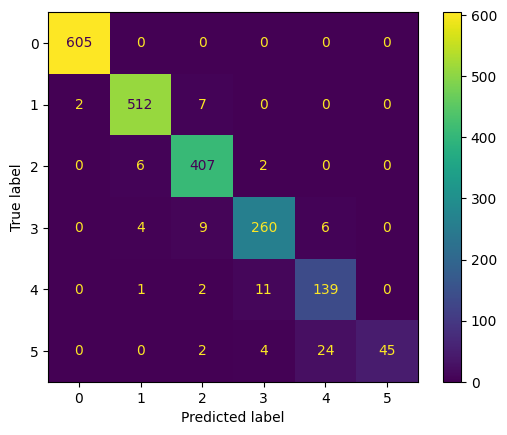

In [172]:
cm = confusion_matrix(y_true, predictions_rf, labels=model_rf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_rf.classes_)

disp.plot()
plt.show()

**Testing Tensorflow**

In [266]:
predictions_tf = model.predict(X_new)
predictions_tf

64/64 [==============================] - 0s 5ms/step


array([[2.2492353e-03, 9.1656884e-03, 9.8841101e-01, 4.7027150e-20,
        2.2679652e-15, 1.7398878e-04],
       [1.7119281e-01, 5.1206613e-01, 2.3119920e-01, 1.5580821e-03,
        4.4646440e-03, 7.9519160e-02],
       [2.1188132e-02, 7.1975544e-02, 9.0314627e-01, 7.7436928e-13,
        6.3580236e-10, 3.6901501e-03],
       ...,
       [1.0816936e-03, 1.2066427e-03, 9.9763393e-01, 1.1666112e-21,
        1.0938151e-16, 7.7831959e-05],
       [4.1175303e-05, 4.3443833e-06, 9.9994999e-01, 1.0734831e-27,
        6.1586412e-21, 4.3597902e-06],
       [1.5959494e-02, 2.5450451e-02, 9.5191312e-01, 2.4428676e-10,
        7.4800099e-08, 6.6767358e-03]], dtype=float32)

In [267]:
predictions_tf_norm = np.argmax(predictions_tf, axis=1)
predictions_tf_norm

array([2, 1, 2, ..., 2, 2, 2])

In [ ]:
confidence = np.argmax(prediction_proba, axis=1)

In [270]:
accuracy_tf = accuracy_score(y_true, predictions_tf_norm)
accuracy_tf

0.2216796875

**Testing Linear Regression**

In [271]:
predictions_lr = model_lr.predict(X_new)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [272]:
accuracy_lr = accuracy_score(y_true, predictions_lr)
accuracy_lr

0.03662109375

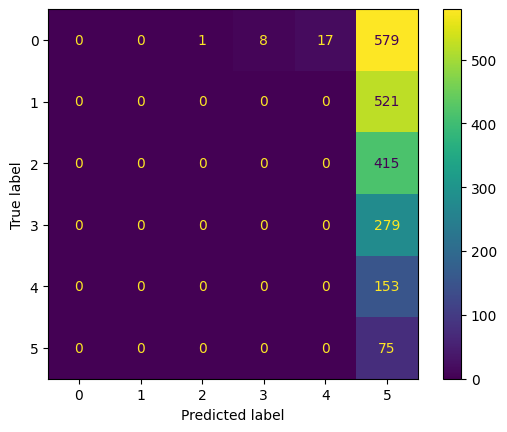

In [273]:
cm = confusion_matrix(y_true, predictions_lr, labels=model_lr.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_rf.classes_)

disp.plot()
plt.show()

# My Conclusion

After conducting 3 different tests, I determined Random Forest Classifier performed the best on the actual data being used in the project and on new data. It was able to generalize very well without overfitting